In [1]:
import json
from itertools import product
import typing
import glob

import numpy as np
import pandas as pd
from lmfit.models import ExpressionModel
import matplotlib.pyplot as plt
import altair as alt
from altair import datum

In [2]:
filename = "Data/Ne photoelectron density - TDCASSCF - Filelist.xlsx"
weight = pd.read_excel(filename, "Weights", index_col="Ang (rad)")["Weight"]

In [3]:
def read(filename: str) -> pd.DataFrame:
    with open(filename, "r") as fp:
        data = json.load(fp)

    d = data["Data"][0]
    q = np.array(d["Mag q num"]["Values"])
    r = np.array(d["Momentum (au)"]["Values"])
    theta = np.array(d["Polar ang (rad)"]["Values"])
    idx = pd.MultiIndex.from_product([q, theta],
                                     names=["Mag q num", "Polar ang (rad)"])

    eps = np.finfo(np.float16).eps
    if not (theta - weight.index < eps).all():
        raise ValueError("Invalid table!")

    rho = np.array(d["Density"]["Values"])
    at = (rho * weight[None, None, :]).sum((0, 2)).argmax()

    def gen() -> typing.Iterator[dict]:
        for d in data["Data"]:
            if not ((np.array(d["Mag q num"]["Values"]) == q).all()
                    and (np.array(d["Momentum (au)"]["Values"]) == r).all()
                    and (np.array(d["Polar ang (rad)"]["Values"]) == theta).all()):
                raise ValueError("Invalid table!")

            arr = np.array(d["Density"]["Values"])[:, at, :]
            for (i, j), k in zip(product(q, theta), arr.reshape(-1)):
                if i < 0:
                    continue
                yield {"Group": data["Group"],
                       "Photon energy (eV)": d["Photon energy (eV)"],
                       "Opt phase (deg)": d["Opt phase (deg)"],
                       "Config": f"m={i}",
                       "Polar ang (rad)": j,
                       "Density": k}
            for j, k in zip(theta, arr.sum(0)):
                yield {"Group": data["Group"],
                       "Photon energy (eV)": d["Photon energy (eV)"],
                       "Opt phase (deg)": d["Opt phase (deg)"],
                       "Config": "sum[m]",
                       "Polar ang (rad)": j,
                       "Density": k}
    return pd.DataFrame(list(gen()))

In [4]:
patt = "Data/Ne photoelectron density - TDCASSCF - G*.json"
expanded = pd.concat((read(fn) for fn in glob.iglob(patt)), ignore_index=False)
expanded.head()

Config   Density  Group  Opt phase (deg)  Photon energy (eV)  \
0    m=0  0.021030  G1654                0               16.54   
1    m=0  0.018642  G1654                0               16.54   
2    m=0  0.013869  G1654                0               16.54   
3    m=0  0.008362  G1654                0               16.54   
4    m=0  0.003758  G1654                0               16.54   

   Polar ang (rad)  
0         3.141593  
1         2.978504  
2         2.842989  
3         2.708580  
4         2.574496

In [5]:
def fit(df: pd.DataFrame) -> pd.DataFrame:
    where = df["Polar ang (rad)"] < 0.5 * np.pi
    theta = df["Polar ang (rad)"][where].mean()
    x = df["Opt phase (deg)"] / 180 * np.pi
    x[~where] = x[~where] + np.pi
    y = df["Density"]

    model = ExpressionModel("amp * cos(x - shift) + offset")
    model.set_param_hint("amp", value=y.std(), min=0)
    model.set_param_hint("shift", value=x[y.idxmax()])
    model.set_param_hint("offset", value=y.mean())
    result = model.fit(y, x=x)
    
    idx = pd.Index([theta, np.pi - theta], name="Polar ang (rad)")
    amp = result.params["amp"].value
    if amp == 0:
        return pd.DataFrame({"Amp": amp,
                             "Phase shift (rad)": pd.Series([np.nan, np.nan], index=idx)})
    dph = 0.5 * np.pi
    shift = (result.params["shift"].value + dph) % (2 * np.pi) - dph
    return pd.DataFrame({"Amp": amp,
                         "Phase shift (rad)": pd.Series([shift, shift + np.pi], index=idx)})


def norm_phase(df: pd.DataFrame) -> pd.DataFrame:
    where = ~df["Phase shift (rad)"].isna()
    df.loc[where, "Phase shift (rad)"] = np.unwrap(df.loc[where, "Phase shift (rad)"])
    return df


def norm_amp(df: pd.DataFrame) -> pd.DataFrame:
    split = df.reset_index([0, 1, 3], drop=True)
    r = split.loc["m=0", "Amp"] + 2 * split.loc["m=1", "Amp"]
    split["Rel amp"] = split["Amp"] / r
    return split


expanded["Polar ang (idx)"] = (90 - expanded["Polar ang (rad)"] / np.pi * 180).abs().round()
fitted = (
    expanded
    .groupby(["Group", "Photon energy (eV)", "Config", "Polar ang (idx)"])
    .apply(fit)
    .reset_index(level=3, drop=True)
    .sort_index()  # Sort by polar angles
    .groupby(["Group", "Photon energy (eV)", "Config"])
    .apply(norm_phase)
    .groupby(["Group", "Photon energy (eV)", "Polar ang (rad)"])
    .apply(norm_amp)
)
fitted.head()

# filename = "Data/Ne phase shift diffs - TDCASSCF - From PADs.csv"
# fitted.reset_index().to_csv(filename, index=False)

Amp  Phase shift (rad)  \
Group Photon energy (eV) Polar ang (rad) Config                                
G1430 14.3               0.000000        m=0     0.003255           1.033615   
                                         m=1     0.000000                NaN   
                                         sum[m]  0.003255           1.033615   
                         0.163088        m=0     0.002694           1.042097   
                                         m=1     0.000231           1.224096   

                                                  Rel amp  
Group Photon energy (eV) Polar ang (rad) Config            
G1430 14.3               0.000000        m=0     1.000000  
                                         m=1     0.000000  
                                         sum[m]  1.000000  
                         0.163088        m=0     0.853356  
                                         m=1     0.073322

In [6]:
filename = "Data/Ne phase shift diffs.xlsx"
fitted = (
    pd
    .read_excel(filename, sheet_name="TDCASSCF")
    .set_index(["Group", "Photon energy (eV)", "Config", "Polar ang (rad)"])
)
fitted.head()

KE (eV)  Polar ang (deg)  \
Group Photon energy (eV) Config Polar ang (rad)                              
G1430 14.3               m=0    0.000000         4.012611         0.000000   
                                0.163088         4.012611         9.344271   
                                0.298604         4.012611        17.108726   
                                0.433013         4.012611        24.809806   
                                0.567097         4.012611        32.492255   

                                                 Rounded (deg)       Amp  \
Group Photon energy (eV) Config Polar ang (rad)                            
G1430 14.3               m=0    0.000000                     0  0.003255   
                                0.163088                     9  0.002694   
                                0.298604                    17  0.001600   
                                0.433013                    25  0.000467   
                                0.567097                    32  0.000558   

                                                  Rel amp  \
Group Photon energy (eV) Config Polar ang (rad)             
G1430 14.3               m=0    0.000000         1.000000   
                                0.163088         0.853356   
                                0.298604         0.545293   
                                0.433013         0.176430   
                                0.567097         0.178488   

                                                 Phase shift diff (rad)  \
Group Photon energy (eV) Config Polar ang (rad)                           
G1430 14.3               m=0    0.000000                       1.033615   
                                0.163088                       1.042097   
                                0.298604                       1.088459   
                                0.433013                       1.506112   
                                0.567097                       3.357772   

                                                 Phase shift diff (deg)  \
Group Photon energy (eV) Config Polar ang (rad)                           
G1430 14.3               m=0    0.000000                      59.221805   
                                0.163088                      59.707750   
                                0.298604                      62.364093   
                                0.433013                      86.293882   
                                0.567097                     192.386153   

                                                 Phase mod  Unwrapped (rad)  \
Group Photon energy (eV) Config Polar ang (rad)                               
G1430 14.3               m=0    0.000000                 0         1.033615   
                                0.163088                 0         1.042097   
                                0.298604                 0         1.088459   
                                0.433013                 0         1.506112   
                                0.567097                 0         3.357772   

                                                 Unwrapped (deg)  
Group Photon energy (eV) Config Polar ang (rad)                   
G1430 14.3               m=0    0.000000               59.221805  
                                0.163088               59.707750  
                                0.298604               62.364093  
                                0.433013               86.293882  
                                0.567097              192.386153

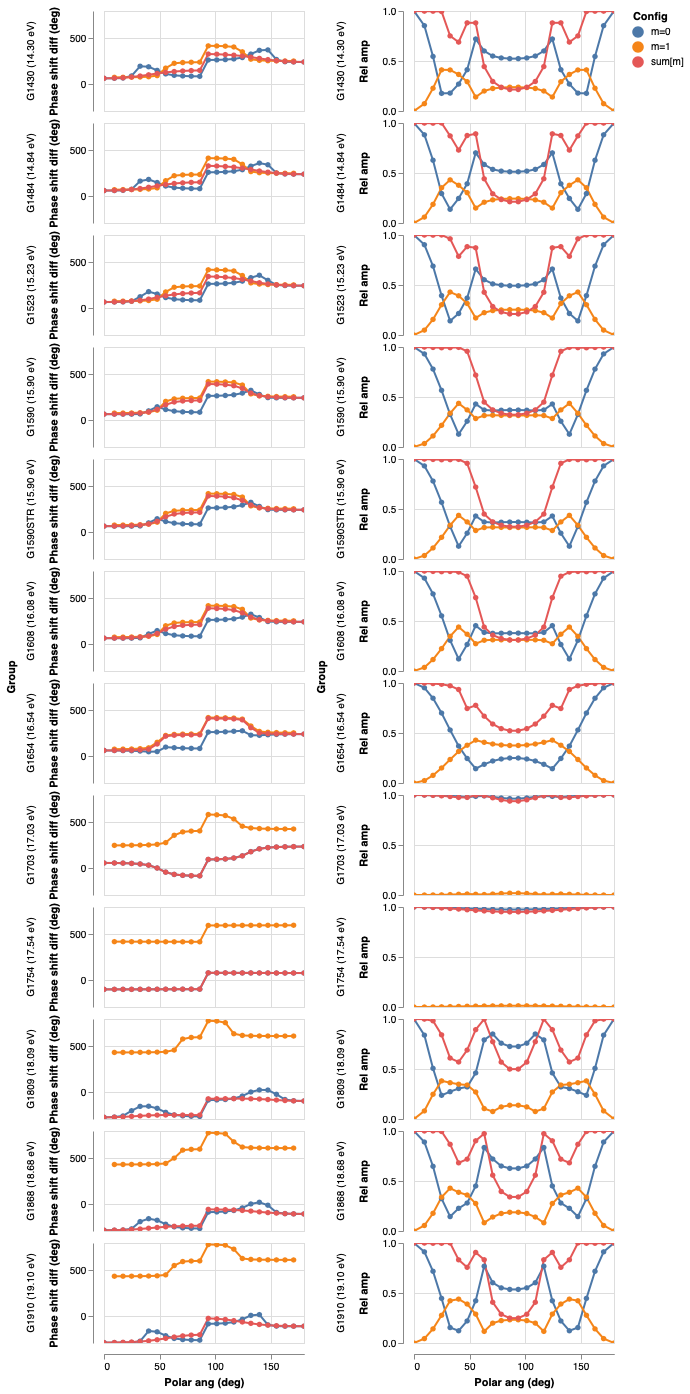

In [15]:
df = fitted.reset_index()
df["Group"] = df.apply(lambda c: "{} ({:.2f} eV)".format(c["Group"], c["Photon energy (eV)"]), axis=1)
df["Phase shift diff (deg)"] = df["Unwrapped (deg)"]

base = (
    alt
    .Chart(df)
    .mark_line(point=True)
    .properties(height=100, width=200)
    .interactive(bind_x=False)
)
(
    base
    .encode(
        x="Polar ang (deg):Q",
        y="Phase shift diff (deg):Q",
        color="Config:N",
        )
    .facet(row="Group:N")
    | base
    .encode(
        x="Polar ang (deg):Q",
        y="Rel amp:Q",
        color="Config:N",
        )
    .facet(row="Group:N")
)

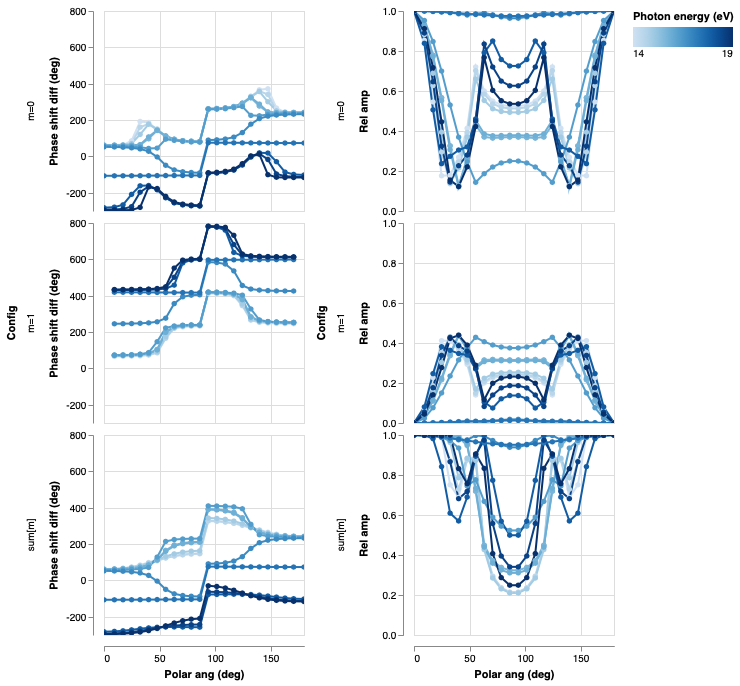

In [17]:
df = fitted.reset_index()
df["Phase shift diff (deg)"] = df["Unwrapped (deg)"]

base = (
    alt
    .Chart(df)
    .mark_line(point=True)
    .properties(height=200, width=200)
    .interactive(bind_x=False)
)
(
    base
    .encode(
        x="Polar ang (deg)",
        y="Phase shift diff (deg)",
        color="Photon energy (eV):Q",
        )
    .facet(row="Config:N")
    | base
    .encode(
        x="Polar ang (deg)",
        y="Rel amp",
        color="Photon energy (eV):Q",
        )
    .facet(row="Config:N")
)

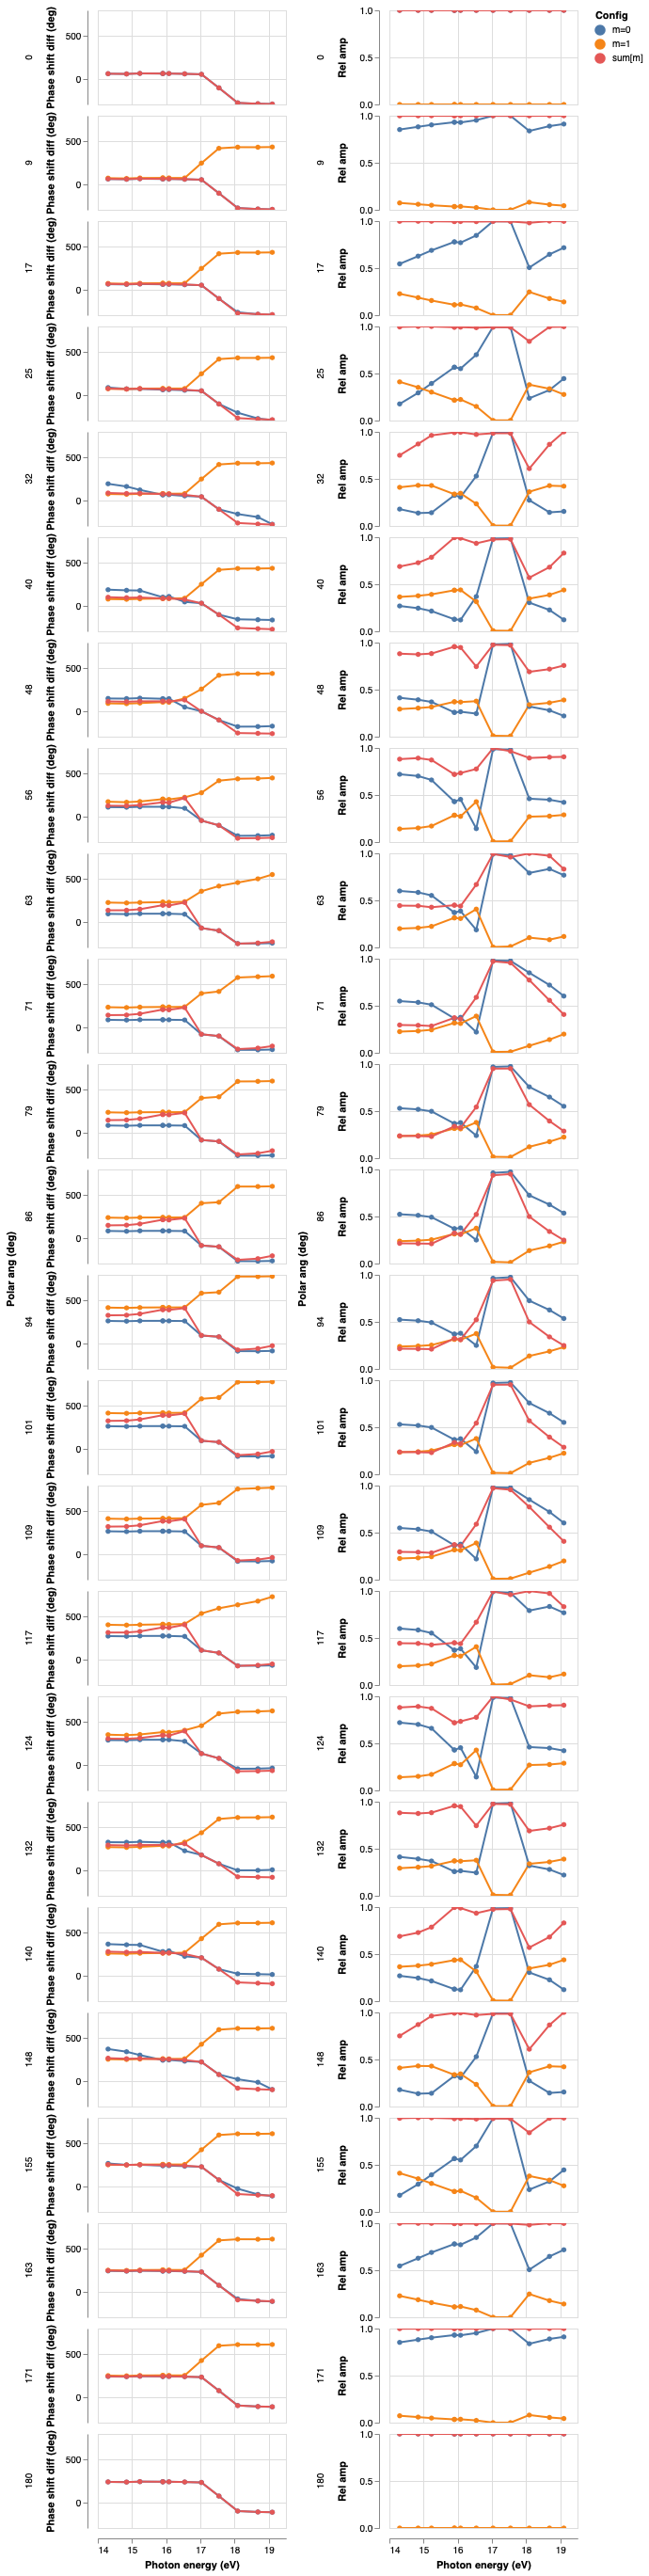

In [13]:
df = fitted.reset_index()
df["Phase shift diff (deg)"] = df["Unwrapped (deg)"]
df["Polar ang (deg)"] = df["Polar ang (deg)"].round()

base = (
    alt
    .Chart(df)
    .mark_line(point=True)
    .properties(height=100, width=200)
    .interactive(bind_x=False)
)
(
    base
    .encode(
        x="Photon energy (eV)",
        y="Phase shift diff (deg)",
        color="Config",
        )
    .facet(row="Polar ang (deg)")
    | base
    .encode(
        x="Photon energy (eV)",
        y="Rel amp",
        color="Config",
        )
    .facet(row="Polar ang (deg)")
)

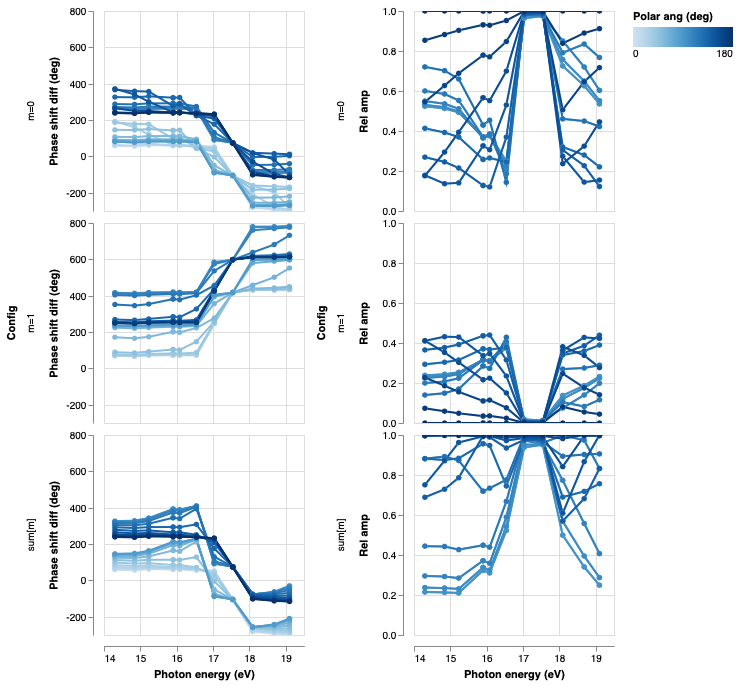

In [18]:
df = fitted.reset_index()
df["Phase shift diff (deg)"] = df["Unwrapped (deg)"]
df["Polar ang (deg)"] = df["Polar ang (deg)"].round()

base = (
    alt
    .Chart(df)
    .mark_line(point=True)
    .properties(height=200, width=200)
    .interactive(bind_x=False)
)
(
    base
    .encode(
        x="Photon energy (eV):Q",
        y="Phase shift diff (deg):Q",
        color="Polar ang (deg):Q",
        )
    .facet(row="Config:N")
    | base
    .encode(
        x="Photon energy (eV):Q",
        y="Rel amp:Q",
        color="Polar ang (deg):Q",
        )
    .facet(row="Config:N")
)

In [19]:
def sloop(df: pd.DataFrame) -> pd.DataFrame:
    x = df["Photon energy (eV)"].values
    index = pd.Index(x[:-1], name="Photon energy fr (eV)")
    dx = 2 * np.diff(x)
    dy = np.diff(df["Unwrapped (rad)"])
    return pd.DataFrame({
        "EWS delay (as)": dy / dx * 24.1888432651 / 0.0367493,
        "Photon energy to (eV)": x[1:],
        "Polar ang (rad)": df["Polar ang (rad)"].mean(),
    }, index=index)


rounded = fitted.reset_index()
rounded["Photon energy (eV)"] = rounded["Photon energy (eV)"].round(2)
diff = (
    rounded
    .groupby(["Photon energy (eV)", "Config", "Rounded (deg)"])
    .mean()
    .sort_index()  # Sort by photon energies
    .reset_index(level=0)
    .groupby(["Config", "Rounded (deg)"])
    .apply(sloop)
)
diff.head()

EWS delay (as)  \
Config Rounded (deg) Photon energy fr (eV)                   
m=0    0             14.30                      -25.571273   
                     14.84                       85.942160   
                     15.23                      -11.819568   
                     15.90                       -9.126020   
                     16.08                      -39.760506   

                                            Photon energy to (eV)  \
Config Rounded (deg) Photon energy fr (eV)                          
m=0    0             14.30                                  14.84   
                     14.84                                  15.23   
                     15.23                                  15.90   
                     15.90                                  16.08   
                     16.08                                  16.54   

                                            Polar ang (rad)  
Config Rounded (deg) Photon energy fr (eV)                   
m=0    0             14.30                              0.0  
                     14.84                              0.0  
                     15.23                              0.0  
                     15.90                              0.0  
                     16.08                              0.0

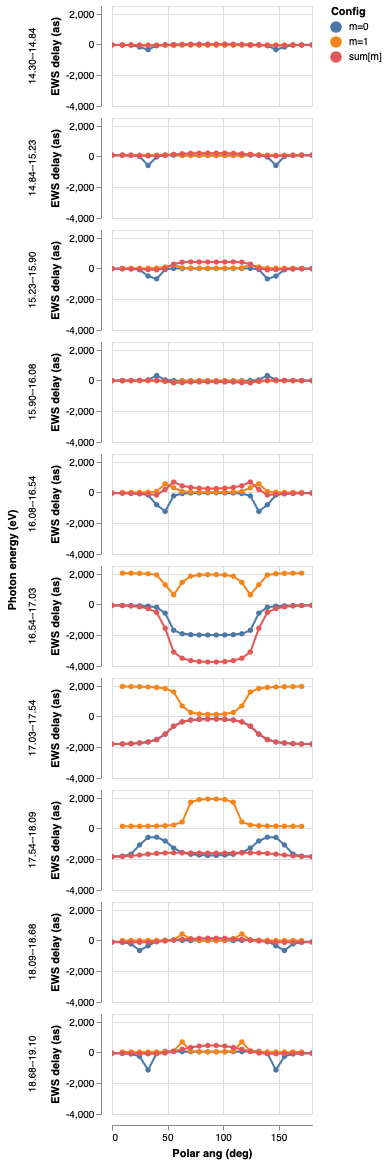

In [22]:
df = diff.reset_index()
df["Polar ang (deg)"] = (df["Polar ang (rad)"] / np.pi * 180)
df["Photon energy (eV)"] = df.apply(lambda c: "{:.2f}--{:.2f}".format(c["Photon energy fr (eV)"],
                                                                      c["Photon energy to (eV)"]),
                                    axis=1)

(
    alt
    .Chart(df)
    .mark_line(point=True)
    .encode(
        x="Polar ang (deg)",
        y="EWS delay (as)",
        color="Config",
        row="Photon energy (eV)",
        )
    .properties(height=100, width=200)
    .interactive(bind_x=False)
)

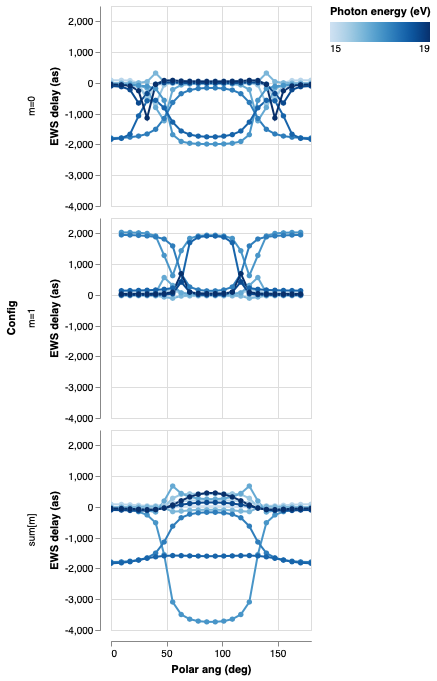

In [26]:
df = diff.reset_index()
df["Polar ang (deg)"] = (df["Polar ang (rad)"] / np.pi * 180)
df["Photon energy (eV)"] = df.apply(lambda c: (c["Photon energy fr (eV)"] + c["Photon energy to (eV)"]) / 2, axis=1)

(
    alt
    .Chart(df)
    .mark_line(point=True)
    .encode(
        x="Polar ang (deg)",
        y="EWS delay (as)",
        color="Photon energy (eV):Q",
        row="Config:N",
        )
    .properties(height=200, width=200)
    .interactive(bind_x=False)
)

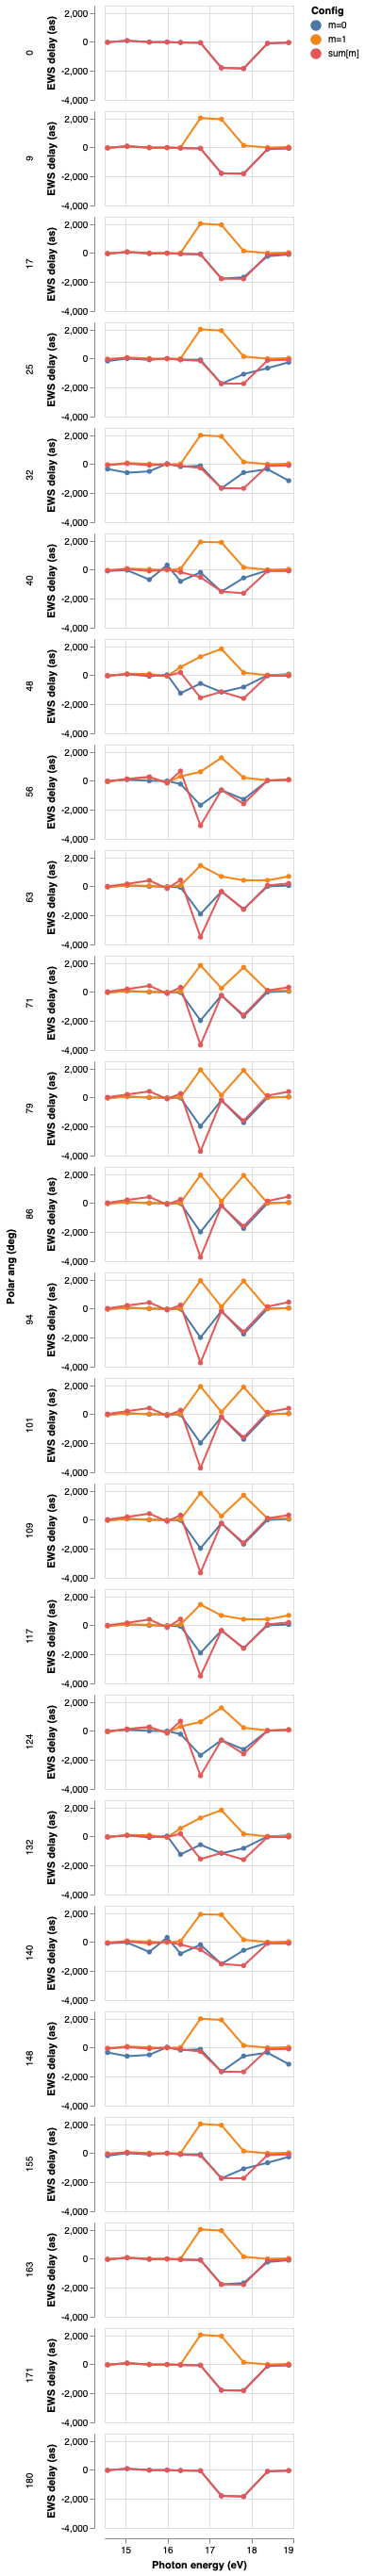

In [27]:
df = diff.reset_index()
df["Polar ang (deg)"] = (df["Polar ang (rad)"] / np.pi * 180).round()
df["Photon energy (eV)"] = df.apply(lambda c: (c["Photon energy fr (eV)"] + c["Photon energy to (eV)"]) / 2, axis=1)

(
    alt
    .Chart(df)
    .mark_line(point=True)
    .encode(
        x="Photon energy (eV)",
        y="EWS delay (as)",
        color="Config",
        row="Polar ang (deg)",
        )
    .properties(height=100, width=200)
    .interactive(bind_x=False)
)

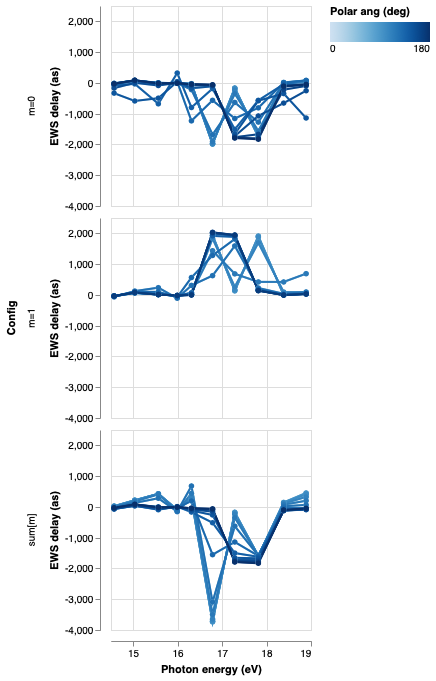

In [29]:
df = diff.reset_index()
df["Polar ang (deg)"] = (df["Polar ang (rad)"] / np.pi * 180).round()
df["Photon energy (eV)"] = df.apply(lambda c: (c["Photon energy fr (eV)"] + c["Photon energy to (eV)"]) / 2, axis=1)

(
    alt
    .Chart(df)
    .mark_line(point=True)
    .encode(
        x="Photon energy (eV):Q",
        y="EWS delay (as):Q",
        color="Polar ang (deg):Q",
        row="Config:N",
        )
    .properties(height=200, width=200)
    .interactive(bind_x=False)
)